# Data Process

In [57]:
# Import packages
import os
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl
import dgl.function as fn

import networkx as nx

In [19]:
# Read the first lines in tran set
i = 0
print('Source IP\tDestination IP\tPort\tTimestamp\tType')
train_data = open('./train_set/train_000.txt')
for line in train_data:
    source_ip, destination_ip, port, timestamp, connection_type = line.split()
    print('{}\t\t{}\t\t{}\t{}\t\t{}'.format(int(source_ip), int(destination_ip), int(port), int(timestamp), connection_type))
    i = i + 1
    if i >= 5:
        break

Source IP	Destination IP	Port	Timestamp	Type
3957		15394		13556	0		-
3957		15394		13556	0		-
15394		4800		35567	308		-
15394		4800		35567	308		-
20367		19350		28415	392		-


In [ ]:
# Train Data Load

train_data_files = os.listdir('train_set/')

nodes = []
edges = []

file_load_flag = 0
for file in train_data_files:
    file_load_flag += 1
    print('Loading File {}/{}...'.format(file_load_flag, len(train_data_files)), end='\r')
    
    file_path = 'train_set/' + file
    train_data = open(file_path)
    for line in train_data:
        source_ip, destination_ip, port, timestamp, connection_type = line.split()
        nodes.append(int(source_ip))
        nodes.append(int(destination_ip))
        edges.append((int(source_ip), int(destination_ip), int(port), int(timestamp), connection_type))

nodes = list(set(nodes))

## Label Mark Function

In [12]:
def label(flag: str) -> int:
    return {
        '-': 0,
        'snmpgetattack': 1,
        'warez': 2,
        'portsweep': 3,
        'nmap': 4,
        'warezclient': 5,
        'ipsweep': 6,
        'dict': 7,
        'neptune': 8,
        'smurf': 9,
        'pod': 10,
        'snmpguess': 11,
        'teardrop': 12,
        'satan': 13,
        'httptunnel-e': 14,
        'ignore': 15,
        'mscan': 16,
        'guest': 17,
        'rootkit': 18,
        'back': 19,
        'apache2': 20,
        'processtable': 21,
        'mailbomb': 22,
        'smurfttl': 23,
        'saint': 24
    }.get(flag)

# Basic DGL Model

In [ ]:
# Load Data

path = 'data/train/train_000.txt'
src = []
dst = []
ports = []
times = []
labels = []

data = open(path)
for line in data:
    src_ip, dst_ip, port, timestamp, connection_type = line.split()
    src.append(int(src_ip))
    dst.append(int(dst_ip))
    ports.append(int(port))
    times.append(int(timestamp))
    labels.append(label(connection_type))

In [ ]:
# Create DGL Graph

graph = dgl.graph((src, dst))
graph.edata['port'] = ports
graph.edata['time'] = times
graph.edata['label'] = labels

In [ ]:
# Predictor Layer

class DotProductPredictor(nn.Module):
    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return graph.edata['score']

In [ ]:
# SAGE Layer

class SAGE(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = dgl.nn.SAGEConv(in_dim, hidden_dim, aggregator_type='mean')
        self.conv2 = dgl.nn.SAGEConv(hidden_dim, out_dim, aggregator_type='mean')
        
    def forward(self, graph, inputs):
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

In [ ]:
# Predictor Model

class SAGEModel(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.sage = SAGE(in_dim, hidden_dim, out_dim)
        self.pred = DotProductPredictor()
        
    def forward(self, graph, x):
        h = self.sage(graph, x)
        return self.pred(graph, h)

In [ ]:
# Train Loop

model = SAGEModel(2, 5, 1)
optim = torch.optim.Adam(model.parameters())

for epoch in range(5):
    output = model(graph, node_features)
    loss = ((output - labels) ** 2).mean()
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    print(loss.item())

# Graph Dataset

841
841
70
113


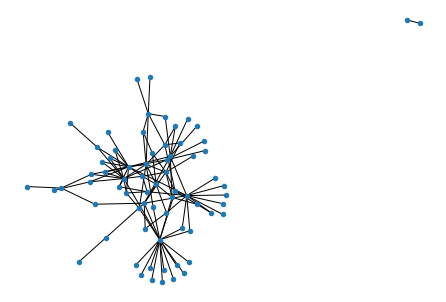

In [43]:
path = 'data/train/train_000.txt'
nodes = []
edges = []

data = open(path)
count = 0
for line in data:
    count += 1
    src_ip, dst_ip, port, timestamp, connection_type = line.split()
    nodes.append(int(src_ip))
    nodes.append(int(dst_ip))
    edges.append((int(src_ip), int(dst_ip)))
    
nodes = list(set(nodes))

G = nx.Graph()

print(len(edges))

G.add_nodes_from(nodes)
G.add_edges_from(edges)

print(count)
print(G.number_of_nodes())
print(G.number_of_edges())

options = {"node_size": 20}
nx.draw(G, **options)

# Test Edge Transfer Node Classification

In [44]:
# Graph Generate

path = 'data/train/train_000.txt'
nodes = []
nodes_in = {}
nodes_out = {}
edges = np.empty([1, 5])

# Feature List
src_ip_list = {}
dst_ip_list = {}
port_list = {}
time_list = {}
label_list = {}

data = open(path)
num_line = 0
for line in data:
    src_ip, dst_ip, port, timestamp, connection_type = line.split()
    
    if (int(src_ip), int(dst_ip)) in edges:
        pass
    
    nodes.append(int(src_ip))
    nodes.append(int(dst_ip))
    edges = np.vstack((edges, [int(src_ip), int(dst_ip), int(port), int(timestamp), label(connection_type)]))
    
    if int(dst_ip) in nodes_in.keys():
        nodes_in[dst_ip].append(num_line)
    else:
        nodes_in[dst_ip] = [num_line]
        
    if int(src_ip) in nodes_out.keys():
        nodes_out[src_ip].append(num_line)
    else:
        nodes_out[src_ip] = [num_line]
        
    num_line += 1
        
nodes = list(set(nodes))
edges = np.delete(edges, obj=0, axis=0)
edge_trans_src = []
edge_trans_dst = []

print(len(nodes))
print(edges.shape)

print(len(nodes_in.keys()))
print(len(nodes_out.keys()))

nodes_cal = list(set(nodes_in.keys()).intersection(set(nodes_out.keys())))

for node in nodes_cal:
    for src_edge in nodes_in[node]:
        for dst_edge in nodes_out[node]:
            edge_trans_src.append(src_edge)
            edge_trans_dst.append(dst_edge)
            
print(len(edge_trans_src))
print(len(edge_trans_dst))

70
(841, 5)
57
27
14
14


In [88]:
# Graph Generate

path = 'data/train/train_000.txt'
nodes = []
nodes_in = {}
nodes_out = {}

# Feature List
src_list = collections.OrderedDict()
dst_list = collections.OrderedDict()
ip_list_trans = collections.OrderedDict()
port_list = collections.OrderedDict()
time_list = collections.OrderedDict()
label_list = collections.OrderedDict()

edge_num = 0

data = open(path)
for line in data:
    src_ip, dst_ip, port, time, connection_type = line.split()
    
    if (int(src_ip), int(dst_ip)) in ip_list_trans.keys():
        edge_num_temp = ip_list_trans[(int(src_ip), int(dst_ip))]
        port_list[edge_num_temp].append(int(port))
        time_list[edge_num_temp].append(int(time))
        label_list[edge_num_temp].append(label(connection_type))
        continue
    
    nodes.append(int(src_ip))
    nodes.append(int(dst_ip))
    
    ip_list_trans[(int(src_ip), int(dst_ip))] = edge_num
    src_list[edge_num] = int(src_ip)
    dst_list[edge_num] = int(dst_ip)
    port_list[edge_num] = [int(port)]
    time_list[edge_num] = [int(time)]
    label_list[edge_num] = [label(connection_type)]
    
    if int(dst_ip) in nodes_in.keys():
        nodes_in[dst_ip].append(edge_num)
    else:
        nodes_in[dst_ip] = [edge_num]
        
    if int(src_ip) in nodes_out.keys():
        nodes_out[src_ip].append(edge_num)
    else:
        nodes_out[src_ip] = [edge_num]
    edge_num += 1
        
nodes = list(set(nodes))
edge_trans_src = []
edge_trans_dst = []

nodes_cal = list(set(nodes_in.keys()).intersection(set(nodes_out.keys())))

for node in nodes_cal:
    for src_edge in nodes_in[node]:
        for dst_edge in nodes_out[node]:
            edge_trans_src.append(src_edge)
            edge_trans_dst.append(dst_edge)
            
            


[85, 81, 57, 90, 99, 31, 48, 109, 43, 105, 82, 106, 63, 0]


In [120]:
# Graph Generate

path = 'data/train/train_000.txt'
nodes = []
nodes_in = {}
nodes_out = {}

# Feature List
src_list = collections.OrderedDict()
dst_list = collections.OrderedDict()
ip_list_trans = collections.OrderedDict()
num_edge_list = collections.OrderedDict()
port_list = []
time_list = []
label_list = []

# ADD UP EDGE
edges = np.empty([1, 4])
edge_num = 0

data = open(path)
for line in data:
    src_ip, dst_ip, port, time, connection_type = line.split()
    
    if (int(src_ip), int(dst_ip)) in ip_list_trans.keys():
        edge_num_temp = ip_list_trans[(int(src_ip), int(dst_ip))]
        num_edge_list[edge_num_temp] += 1
        port_list[edge_num_temp] += int(port)
        time_list[edge_num_temp] += int(time)
        label_list[edge_num_temp] += label(connection_type)
        
        # ADD UP EDGE
        edges = np.vstack((edges, [int(src_ip), int(dst_ip), int(port), int(time)]))
        
        continue
    
    nodes.append(int(src_ip))
    nodes.append(int(dst_ip))
    
    ip_list_trans[(int(src_ip), int(dst_ip))] = edge_num
    src_list[edge_num] = int(src_ip)
    dst_list[edge_num] = int(dst_ip)
    num_edge_list[edge_num] = 1
    port_list.append(int(port))
    time_list.append(int(time))
    label_list.append(label(connection_type))
    
    # ADD UP EDGE
    edges = np.vstack((edges, [int(src_ip), int(dst_ip), int(port), int(time)]))
    
    if int(dst_ip) in nodes_in.keys():
        nodes_in[dst_ip].append(edge_num)
    else:
        nodes_in[dst_ip] = [edge_num]
        
    if int(src_ip) in nodes_out.keys():
        nodes_out[src_ip].append(edge_num)
    else:
        nodes_out[src_ip] = [edge_num]
    edge_num += 1
        
nodes = list(set(nodes))
edge_trans_src = []
edge_trans_dst = []

# ADD UP EDGE
edges = np.delete(edges, obj=0, axis=0)

nodes_cal = list(set(nodes_in.keys()).intersection(set(nodes_out.keys())))

for node in nodes_cal:
    for src_edge in nodes_in[node]:
        for dst_edge in nodes_out[node]:
            edge_trans_src.append(src_edge)
            edge_trans_dst.append(dst_edge)

In [65]:
print(len(nodes))

print(len(ip_list.keys()))
print(len(port_list.keys()))
print(len(time_list.keys()))
print(len(label_list.keys()))

print(len(nodes_in.keys()))
print(len(nodes_out.keys()))

print('Abaaba')
print(len(nodes_cal))

print(len(edge_trans_src))
print(len(edge_trans_dst))

70
113
113
113
113
57
27
Abaaba
14
14
14


In [ ]:
print(len(ip_list.keys()))
print(len(src_list.values()))
print(edge_trans_src)
print(edge_trans_dst)
print(list(port_list.values()))
print(list(time_list.values()))
print(list(label_list.values()))

In [103]:
# time_list = np.array(list(time_list.values()))
print(len(time_list))
print(len(num_edge_list))
for i in range(len(time_list)):
    time_list[i] = time_list[i] / num_edge_list[i]
# print(time_list)

113
113
[313.6666666666667, 308.0, 777.6666666666666, 393.0, 458.5, 453.0, 461.0, 461.0, 461.0, 771.6666666666666, 1030.0, 515.0, 1005.5, 640.0, 648.0, 658.0, 658.0, 659.0, 659.0, 660.0, 763.0, 699.8571428571429, 707.0, 711.0, 899.6666666666666, 714.0, 714.0, 714.0, 788.5, 738.0, 874.5, 983.8762886597938, 798.4166666666666, 792.0, 1172.0, 871.0, 880.0, 881.0, 892.0, 1464.0, 1208.0, 977.0, 1001.5, 1145.2142857142858, 1064.0, 1076.0, 1336.3813559322034, 1117.0, 1162.911111111111, 1165.0, 1177.25, 1177.3636363636363, 1224.0, 1230.0, 1230.0, 1233.0, 1233.0, 1234.0, 1234.0, 1235.0, 1236.0, 1238.0, 1240.0, 1264.0, 1242.0, 1243.0, 1243.0, 1244.7619047619048, 1245.0, 1247.0, 1248.0, 1251.0, 1437.0625, 1357.0, 1432.4545454545455, 1393.0, 1417.0, 1480.0, 1437.0, 1529.5, 1629.4596774193549, 1473.0, 1501.7272727272727, 1563.6, 1505.0, 1548.0, 1549.0, 1550.0, 1550.0, 1550.0, 1551.0, 1552.0, 1553.0, 1554.0, 1555.0, 1556.0, 1556.0, 1575.4285714285713, 1575.3333333333333, 1575.0, 1601.2631578947369, 1

In [109]:
# print(port_list)
for i in range(len(port_list)):
    port_list[i] = port_list[i] / num_edge_list[i]

In [110]:
print(port_list)

[21396.0, 35567.0, 30135.666666666668, 28415.0, 23961.5, 19299.0, 19299.0, 19299.0, 19299.0, 17001.666666666668, 26542.5, 19508.0, 7213.0, 26412.0, 26412.0, 26412.0, 26412.0, 26412.0, 26412.0, 26412.0, 38079.5, 34355.0, 34355.0, 34355.0, 31137.666666666668, 34355.0, 34355.0, 34355.0, 42124.5, 42445.0, 35987.0, 21470.9793814433, 41837.333333333336, 41804.0, 37690.5, 10514.0, 10514.0, 10514.0, 10514.0, 15773.2, 35326.5, 28568.347826086956, 29529.0, 6115.0, 6972.0, 6972.0, 27830.398305084746, 12924.0, 16511.0, 22419.0, 22419.0, 22419.0, 5258.0, 5258.0, 5258.0, 5258.0, 5258.0, 5258.0, 5258.0, 5258.0, 5258.0, 5258.0, 5258.0, 15724.0, 5258.0, 5258.0, 5258.0, 5258.0, 5258.0, 5258.0, 5258.0, 5258.0, 30584.75, 33401.0, 19097.363636363636, 12407.0, 12407.0, 22992.0, 12407.0, 24996.5, 23883.540322580644, 28034.0, 28468.18181818182, 27755.4, 28034.0, 33577.0, 33577.0, 33577.0, 33577.0, 33577.0, 33577.0, 33577.0, 33577.0, 33577.0, 33577.0, 33577.0, 33577.0, 37586.0, 37586.0, 37586.0, 37586.0, 37586

In [111]:
for i in range(len(label_list)):
    label_list[i] = label_list[i] / num_edge_list[i]
print(label_list)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [112]:
graph = dgl.DGLGraph()
graph.add_nodes(len(ip_list.keys()))
graph.add_edges(edge_trans_src, edge_trans_dst)
print(graph.number_of_nodes())
print(graph.number_of_edges())

graph.ndata['src_ip'] = torch.tensor(list(src_list.values()))
graph.ndata['dst_ip'] = torch.tensor(list(dst_list.values()))
graph.ndata['port'] = torch.tensor(list(port_list.values()))
graph.ndata['time'] = torch.tensor(list(time_list.values()))
graph.ndata['label'] = torch.tensor(list(label_list.values()))


# graph.ndata['src_ip'] = torch.tensor(edges[:, 0])
# graph.ndata['dst_ip'] = torch.tensor(edges[:, 1])
# graph.ndata['port'] = torch.tensor(edges[:, 2])
# graph.ndata['time'] = torch.tensor(edges[:, 3])
# graph.ndata['label'] = torch.tensor(edges[:, 4])

113
14


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


AttributeError: 'list' object has no attribute 'values'

In [113]:
graph = dgl.DGLGraph()
graph.add_nodes(len(ip_list.keys()))
graph.add_edges(edge_trans_src, edge_trans_dst)
print(graph.number_of_nodes())
print(graph.number_of_edges())

graph.ndata['src_ip'] = torch.tensor(list(src_list.values()))
graph.ndata['dst_ip'] = torch.tensor(list(dst_list.values()))
graph.ndata['port'] = torch.tensor(port_list)
graph.ndata['time'] = torch.tensor(time_list)
graph.ndata['label'] = torch.tensor(label_list)


# graph.ndata['src_ip'] = torch.tensor(edges[:, 0])
# graph.ndata['dst_ip'] = torch.tensor(edges[:, 1])
# graph.ndata['port'] = torch.tensor(edges[:, 2])
# graph.ndata['time'] = torch.tensor(edges[:, 3])
# graph.ndata['label'] = torch.tensor(edges[:, 4])

113
14


In [116]:
print(graph.number_of_nodes())
print(graph.number_of_edges())

113
14


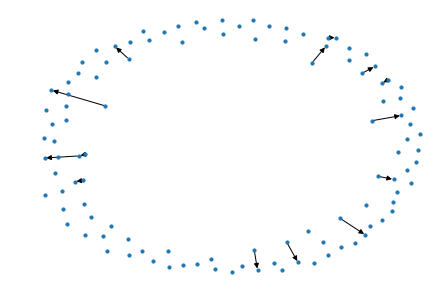

In [54]:
options = {"node_size": 10}
nx.draw(graph.to_networkx(), with_labels=False, **options)

## Fixed Data Load

For edge's features

In [ ]:
# Graph Generate

path = 'data/train/train_000.txt'
nodes = []

# Used to Create Graph
nodes_in = {}
nodes_out = {}

in_nodes_ip = {}
out_nodes_ip = {}

nodes_in_degree = {}
nodes_out_degree = {}

# Feature List
src_list = collections.OrderedDict()
dst_list = collections.OrderedDict()
ip_list_trans = collections.OrderedDict()
num_edge_list = collections.OrderedDict()
port_list = collections.OrderedDict()
time_list = []
label_list = []

edge_num = 0

data = open(path)
for line in data:
    src_ip, dst_ip, port, time, connection_type = line.split()
    
    if (int(src_ip), int(dst_ip)) in ip_list_trans.keys():
        edge_num_temp = ip_list_trans[(int(src_ip), int(dst_ip))]
        
        in_nodes_ip[edge_num_temp].append(int(src_ip))
        out_nodes_ip[edge_num_temp].append(int(dst_ip))
        
        nodes_in_degree[int(dst_ip)] += 1
        nodes_out_degree[int(src_ip)] += 1
        
        num_edge_list[edge_num_temp] += 1
        time_list[edge_num_temp] += int(time)
        label_list[edge_num_temp] += label(connection_type)
        
        if int(port) in port_list[edge_num_temp]:
            continue
        else:
            port_list[edge_num_temp].append(int(port))
        
        continue
    
    nodes.append(int(src_ip))
    nodes.append(int(dst_ip))
    
    if int(dst_ip) in nodes_in_degree.keys():
        nodes_in_degree[int(dst_ip)] += 1
    else:
        nodes_in_degree[int(dst_ip)] = 1
    if int(src_ip) in nodes_out_degree.keys():
        nodes_out_degree[int(src_ip)] += 1
    else:
        nodes_out_degree[int(src_ip)] = 1
    
    in_nodes_ip[edge_num] = [int(src_ip)]
    out_nodes_ip[edge_num] = [int(dst_ip)]
    
    ip_list_trans[(int(src_ip), int(dst_ip))] = edge_num
    num_edge_list[edge_num] = 1
    port_list[edge_num] = [int(port)]
    time_list.append(int(time))
    label_list.append(label(connection_type))
    
    
    if int(dst_ip) in nodes_in.keys():
        nodes_in[dst_ip].append(edge_num)
    else:
        nodes_in[dst_ip] = [edge_num]
        
    if int(src_ip) in nodes_out.keys():
        nodes_out[src_ip].append(edge_num)
    else:
        nodes_out[src_ip] = [edge_num]
    edge_num += 1
        
nodes = list(set(nodes))
edge_trans_src = []
edge_trans_dst = []

nodes_cal = list(set(nodes_in.keys()).intersection(set(nodes_out.keys())))

for node in nodes_cal:
    for src_edge in nodes_in[node]:
        for dst_edge in nodes_out[node]:
            edge_trans_src.append(src_edge)
            edge_trans_dst.append(dst_edge)

# Test GCN

In [127]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

In [128]:
net = GCN(4, 8, 1)

inputs = torch.tensor(edges)
labels = torch.tensor(label_list)

import itertools

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []

for epoch in range(5):
    outputs = net(G, inputs)
    all_logits.append(outputs.detach())
    logp = F.log_softmax(outputs, 1)
    loss = F.nll_loss(logp, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

AttributeError: 'Graph' object has no attribute 'local_scope'

In [124]:
embed = nn.Embedding(34, 5)  # 34 nodes with embedding dim equal to 5
inputs = embed.weight
print(inputs)
inputs = torch.tensor(edges)
print(inputs)
# print(label_list)
labels = torch.tensor(label_list)

Parameter containing:
tensor([[ 0.8246, -0.1906,  1.2754,  0.4698, -1.3570],
        [ 0.7719, -1.8789,  1.0654,  0.8230,  1.8617],
        [-0.0866,  0.9811, -1.5231,  1.6908,  0.8858],
        [ 1.5018,  0.3441,  1.6450,  0.3878, -0.0596],
        [ 0.3118,  0.5502,  0.3589,  1.0514,  0.1535],
        [ 0.0906,  0.5379,  0.7461,  1.1942,  0.0101],
        [ 1.5230,  0.8418, -0.5711, -1.1333,  1.1635],
        [-0.6574, -1.4000, -0.4235, -1.6046,  1.4157],
        [ 0.0067, -0.0286,  0.3520,  0.1327,  1.2163],
        [-0.0348,  0.2608,  0.5652,  0.2905,  1.3915],
        [ 0.6491, -0.5192, -0.1072,  1.7798, -0.8679],
        [-0.4581,  1.6383,  1.3244,  1.5988, -2.0479],
        [-0.7217,  0.1399, -0.6149, -1.3169, -0.7735],
        [ 0.3606, -0.1396, -0.5653,  0.6796,  0.3161],
        [-0.7171, -0.5231, -1.5098,  0.4951,  0.5634],
        [ 0.9327,  0.6712, -0.1886, -1.7913, -0.4172],
        [-1.7446, -2.7783, -2.1129, -1.9988, -0.6813],
        [ 0.9399, -0.7510,  0.3755,  0.3459

# Test GraphSAGE Edge Classification

In [7]:
# Graph Generate

path = 'data/train/train_000.txt'
src = []
dst = []
ports = []
times = []
labels = []

data = open(path)
for line in data:
    src_ip, dst_ip, port, timestamp, connection_type = line.split()
    src.append(int(src_ip))
    dst.append(int(dst_ip))
    ports.append(int(port))
    times.append(int(timestamp))
    labels.append(label(connection_type))
    
graph = dgl.graph((src, dst))
graph.edata['port'] = torch.tensor(ports)
graph.edata['time'] = torch.tensor(times)
graph.edata['label'] = torch.tensor(labels)

In [10]:
# Print Graph Status

print(len(src))
print(len(dst))

print(graph.number_of_nodes())
print(graph.number_of_edges())

841
841
23318
841


In [ ]:
class SAGE(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = dgl.nn.SAGEConv(in_dim, hidden_dim, aggregator_type='mean')
        self.conv2 = dgl.nn.SAGEConv(hidden_dim, out_dim, aggregator_type='mean')
        
    def forward(self, graph, inputs):
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

# Example

In [115]:
nn.Embedding(34, 5)
print(nn.Embedding(34, 5))

Embedding(34, 5)


In [11]:
###############################################################################
# Tutorial problem description
# ----------------------------
#
# The tutorial is based on the "Zachary's karate club" problem. The karate club
# is a social network that includes 34 members and documents pairwise links
# between members who interact outside the club.  The club later divides into
# two communities led by the instructor (node 0) and the club president (node
# 33). The network is visualized as follows with the color indicating the
# community:
#
# .. image:: https://data.dgl.ai/tutorial/img/karate-club.png
#    :align: center
#
# The task is to predict which side (0 or 33) each member tends to join given
# the social network itself.


###############################################################################
# Step 1: Creating a graph in DGL
# -------------------------------
# Create the graph for Zachary's karate club as follows:

import dgl
import numpy as np

def build_karate_club_graph():
    # All 78 edges are stored in two numpy arrays. One for source endpoints
    # while the other for destination endpoints.
    src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
        10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
        25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
    dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
        5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
        24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
        29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
        31, 32])
    # Edges are directional in DGL; Make them bi-directional.
    u = np.concatenate([src, dst])
    v = np.concatenate([dst, src])
    # Construct a DGLGraph
    return dgl.graph((u, v))

G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

# import networkx as nx
# nx_G = G.to_networkx().to_undirected()
# pos = nx.kamada_kawai_layout(nx_G)
# nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

import torch
import torch.nn as nn
import torch.nn.functional as F

embed = nn.Embedding(34, 5)  # 34 nodes with embedding dim equal to 5
G.ndata['feat'] = embed.weight

# print(G.ndata['feat'][2])
# print(G.ndata['feat'][[10, 11]])

from dgl.nn.pytorch import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

net = GCN(5, 5, 2)

inputs = embed.weight
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

import itertools

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(10):
    logits = net(G, inputs)
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

###############################################################################
# This is a rather toy example, so it does not even have a validation or test
# set. Instead, Since the model produces an output feature of size 2 for each node, we can
# visualize by plotting the output feature in a 2D space.
# The following code animates the training process from initial guess
# (where the nodes are not classified correctly at all) to the end
# (where the nodes are linearly separable).

# import matplotlib.animation as animation
# import matplotlib.pyplot as plt

# def draw(i):
#     cls1color = '#00FFFF'
#     cls2color = '#FF00FF'
#     pos = {}
#     colors = []
#     for v in range(34):
#         pos[v] = all_logits[i][v].numpy()
#         cls = pos[v].argmax()
#         colors.append(cls1color if cls else cls2color)
#     ax.cla()
#     ax.axis('off')
#     ax.set_title('Epoch: %d' % i)
#     nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
#             with_labels=True, node_size=300, ax=ax)

# fig = plt.figure(dpi=150)
# fig.clf()
# ax = fig.subplots()
# draw(0)  # draw the prediction of the first epoch
# plt.close()

# ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)

We have 34 nodes.
We have 156 edges.
Epoch 0 | Loss: 0.8276
Epoch 1 | Loss: 0.7819
Epoch 2 | Loss: 0.7408
Epoch 3 | Loss: 0.7028
Epoch 4 | Loss: 0.6669
Epoch 5 | Loss: 0.6327
Epoch 6 | Loss: 0.5998
Epoch 7 | Loss: 0.5681
Epoch 8 | Loss: 0.5383
Epoch 9 | Loss: 0.5096


Hey guys, I have tried three methods so far. 

Firstly, as Mansur mentioned before, I set edge features with (source ip, target, ip, port, time length), and node features with averaging edges' features connected with them. Simmlarly I occured the problem of embedding edge features in GraphSAGE layer of DGL. Seems DGL doesn't give much importance to this method, so I put this aside temporarly. 

Since we are encouraged to use noval methods, I was thinking can we transform edges to nodes, nodes to edges, which allows us to use node classification ways. So I designed a transform stratage to convert the origin graph to a new one, with the nodes were whose egdes in origin graph. Then based on this new graph, I used GCN and GraphSAGE created two models. But, the results were hmmm... terrible. I will show my transform method and the resons I guess about bad resutls to you later, after I generating some images. 

But anyway I think this method is quite novel, I am continuely optimizaing it, and find the reason about poor performance so far, which can also be shown in our report. 